In [1]:
import os
import pandas as pd
import datetime
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer
# 引用 tweetTextHandler.ipynb
import ipynb.fs.defs.TweetTextHandler as tweetTextHandler
import operator
global stop_words
stop_words = stopwords.words('english')

In [2]:
def getWordsDict(texts):
    global stop_words
    wordDict = dict()
    stopwordDict = dict()
    stopwordTweetCount = 0
    tknzr = TweetTokenizer()

    for txt in texts:
        stopwordFlag = False
        try:
            txt = tweetTextHandler.del_url(txt)
            for token in tknzr.tokenize(txt):
                #token = porter.stem(token.lower())
                if token.isdigit():
                    pass
                elif token in stop_words:
                    stopwordDict[token] = stopwordDict.get(token, 0) + 1
                    stopwordFlag = True
                else:
                    wordDict[token] = wordDict.get(token, 0) + 1
            if stopwordFlag:
                stopwordTweetCount += 1
        except Exception as e:
            #print("Error message:", e)
            pass
    return wordDict, stopwordDict, stopwordTweetCount

In [3]:
class Patient(object):
    totalCount = 0
    diagnosedTimeAndText = dict()
    with open('../0_dataset/diagnosed_tweets.csv') as open_file:
        for line in open_file.readlines():
            line = line.strip().split('\t')
            diagnosedTimeAndText[line[1]] = (line[0], line[2])
       
    def __init__(self, name):
        self.name = name
        self.df = pd.read_csv('../0_dataset/DepressionUsersTweets/'+name,sep='\t',header=None,usecols=[2,3],names=['Date','Text'],quoting=3,error_bad_lines=False,encoding='utf-8',keep_default_na=False).dropna(axis=0, how='any')
        self.diagnosedTime = datetime.datetime.strptime(Patient.diagnosedTimeAndText[name][1], "%Y-%m-%d %H:%M:%S")
        self.diagnosedTweet = Patient.diagnosedTimeAndText[name][0]
        
        beforeDiagosedTime = str(self.diagnosedTime - datetime.timedelta(days=90))
        self.inRangeDf = self.df[self.df['Date'].between(beforeDiagosedTime, str(self.diagnosedTime))]
        
        Patient.totalCount += 1 
        
    def displayCount(self):
        print("Total Patients {0}".format(Patient.totalCount))
    
    def displayTweetsCount(self, category='inRange'):
        if category == 'inRange':
            return len(self.inRangeDf)
        elif category == 'all':
            return len(self.df)
        else:
            print('Please indicate category (inRange or all)')
            return False
        
    def getText(self, category='inRange'):
        if category == 'inRange':
            return self.inRangeDf['Text'].values
        elif category == 'all':
            return self.df['Text'].values
        else:
            print('Please indicate category (inRange or all)')
            return False

In [4]:
class Ordinary(object):
    totalCount = 0

    def __init__(self, name):
        self.name = name
        self.df = pd.read_csv('../0_dataset/ordinaryUsersTweets/'+name,sep='\t',header=None,usecols=[2,3],names=['Date','Text'],quoting=3,error_bad_lines=False,encoding='utf-8',keep_default_na=False).dropna(axis=0, how='any')
        # The method to get the latest tweet is wrong
        try:
            self.latestTweetTime = datetime.datetime.strptime(str(self.df.iloc[-1]['Date']), "%Y-%m-%d %H:%M:%S")
        except:
            print(name)
            raise Exception()
        
        self.latestTweetText = self.df.iloc[-1]['Text']
        beforeLatestTweetTime = str(self.latestTweetTime - datetime.timedelta(days=90))
        self.inRangeDf = self.df[self.df['Date'].between(beforeLatestTweetTime, str(self.latestTweetTime))]
        
        Ordinary.totalCount += 1 
        
    def displayCount(self):
        print("Total Ordinarys {0}".format(Ordinary.totalCount))
    
    def displayTweetsCount(self, category='inRange'):
        if category == 'inRange':
            return len(self.inRangeDf)
        elif category == 'all':
            return len(self.df)
        else:
            print('Please indicate category (inRange or all)')
            return False
        
    def getText(self, category='inRange'):
        if category == 'inRange':
            return self.inRangeDf['Text'].values
        elif category == 'all':
            return self.df['Text'].values
        else:
            print('Please indicate category (inRange or all)')
            return False

In [5]:
patients = dict()
ordinarys = dict()

In [6]:
with open('../0_dataset/patient_ids') as r:
    for patient in r.readlines()[:100]:
        patient = patient.strip()
        patients[patient] = Patient(patient)

In [7]:
with open('../0_dataset/ordinary_ids') as r:
    for ordinary in r.readlines()[:100]:
        ordinary = ordinary.strip()
        ordinarys[ordinary] = Ordinary(ordinary)

In [27]:
import plotly
# import plotly.offline as offline
import plotly.plotly as py
import plotly.graph_objs as go
# from IPython.display import display
plotly.tools.set_credentials_file(username='Adeline', api_key='Z5eltNtBQXqvI05ZFQtz')
# offline.init_notebook_mode(connected=True)

In [397]:
_x = list(range(len(total[0])))
_y = list()
_y2 = list()
_z = total[0]
for i, s in enumerate(total[1]):
    try:
        _y.append(round(s/total[2][i],1))
    except ZeroDivisionError:
        _y.append(0)
    
    _y2.append(round(total[2][i]/total[3][i],1))

trace1 = go.Scatter(
    x = _x,
    y = _y,
    hoverinfo='text',
    text=_z,
    mode = 'lines'
)

trace2 = go.Scatter(
    x = _x,
    y = _y2,
    hoverinfo='text',
    text=_z,
    mode = 'lines'
)

data = [trace1, trace2]
layout = go.Layout(
    title='Stopwords 佔每人每篇推文的數量',
    xaxis=dict(
        title='',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Stopwords 數量',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
fig = go.Figure(data=data, layout=layout)

In [398]:
py.iplot(fig)

In [382]:
total2 = [[],[],[],[]]

In [383]:
for key in ordinarys:
    _w, _s, _sc = getWordsDict(ordinarys[key].getText())
    total2[0].append(key)
    total2[1].append(sum(_s.values()))
    total2[2].append(_sc)
    total2[3].append(len(ordinarys[key].inRangeDf))

In [395]:
_x = list(range(len(total2[0])))
_y = list()
_z = total2[0]
for i, s in enumerate(total2[1]):
    try:
        _y.append(round(s/total2[2][i],1))
    except ZeroDivisionError:
        _y.append(0)

trace = go.Scatter(
    x = _x,
    y = _y,
    hoverinfo='text',
    mode = 'lines',
    text=_z
)
data = [trace]
layout = go.Layout(
    title='Stopwords 佔每人每篇推文的數量',
    xaxis=dict(
        title='',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Stopwords 數量',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
fig2 = go.Figure(data=data, layout=layout)

In [396]:
py.iplot(fig2)

In [9]:
total3 = [0, 0, 0]
for key in patients:
    _w, _s, _sc = getWordsDict(patients[key].getText())
    total3[0] += sum(_s.values())
    total3[1] += _sc
    total3[2] += len(patients[key].inRangeDf)
    
# 0:Stopwords總數/ 1:含有stopwords的推文總數/ 2:（時間內的）推文總數

In [10]:
total4 = [0, 0, 0]
for key in ordinarys:
    _w, _s, _sc = getWordsDict(ordinarys[key].getText())
    total4[0] += sum(_s.values())
    total4[1] += _sc
    total4[2] += len(ordinarys[key].inRangeDf)

# 0:Stopwords總數/ 1:含有stopwords的推文總數/ 2:（時間內的）推文總數

In [32]:
trace_patients = go.Bar(x=['Type1', 'Type2'],
                  y=[round(total3[0]/total3[1],1), round(total3[1]/total3[2],1)],
                  name='Patients',
                  marker=dict(color='#ffcdd2'))

trace_ordinarys = go.Bar(x=['Type1', 'Type2'],
                y=[round(total4[0]/total4[1],1), round(total4[1]/total4[2],1)],
                name='Ordinarys',
                marker=dict(color='#A2D5F2'))
data = [trace_patients, trace_ordinarys]

layout = go.Layout(title='比較',
                xaxis=dict(title='使用者類型'),
                yaxis=dict(title='平均數量'))

fig3 = go.Figure(data=data, layout=layout)
py.image.save_as(fig3, filename='img/a-simple-plot.png')

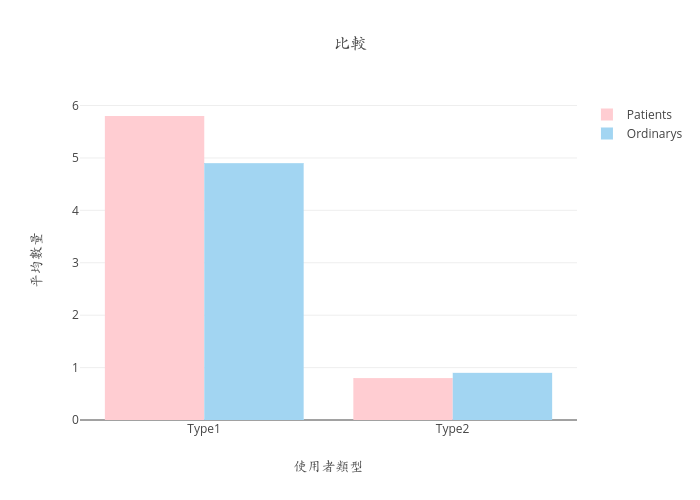

In [34]:
# py.iplot(fig3)
# 上傳至 Github 之後會看不到圖片，因此將結果下載成圖片，再載入該圖片
from IPython.display import Image
Image('img/a-simple-plot.png')